# Berlin marathon results
In this Jupyter notebook we download the data about all the runners that completed the Berlin Marathon in 2021. The output of this file is a single CSV file, which will be further processed for the needs of the intended analysis.

## Packages
First of all, all required packeges will be imported. Above all, we use methods from requests to download the site content, BeautifulSoup to read it, pandas for basic processing of tables and numpy for working with different object types.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
from time import sleep

Let's verify, that we are allowed to scrape from the website.

In [2]:
requests.get('https://berlin.r.mikatiming.net/robots.txt')

<Response [200]>

The request was successful and we are allowed to scrape.

Before moving to the actual scraping, let's sum up what we want to scrape and how we will proceed. Lot of information can be obtained from the actual results list, but that is not enough for us. We are even interested about the pace of each athlete at the certain parts of the marathon course. And this kind of information is available (together with basic info from the results list) at each persons page. 

That means that from the results list we are going to obtain just the link to the page of each runner and than we will scrape all data we need from those pages.

## Link to the page of each runner

We need to specify the structure of the URL link from which we are going to obtain the link to each page.

The very basic link to the result list looks as follows: https://berlin.r.mikatiming.net/2021/ (we can see that we could easily obtain the results from the previous years just by adding another argument to the loop later, but we will stick to just 2021 now). 

To build the full link for scraping all the results we need to apply the filters on the page (see the picture)

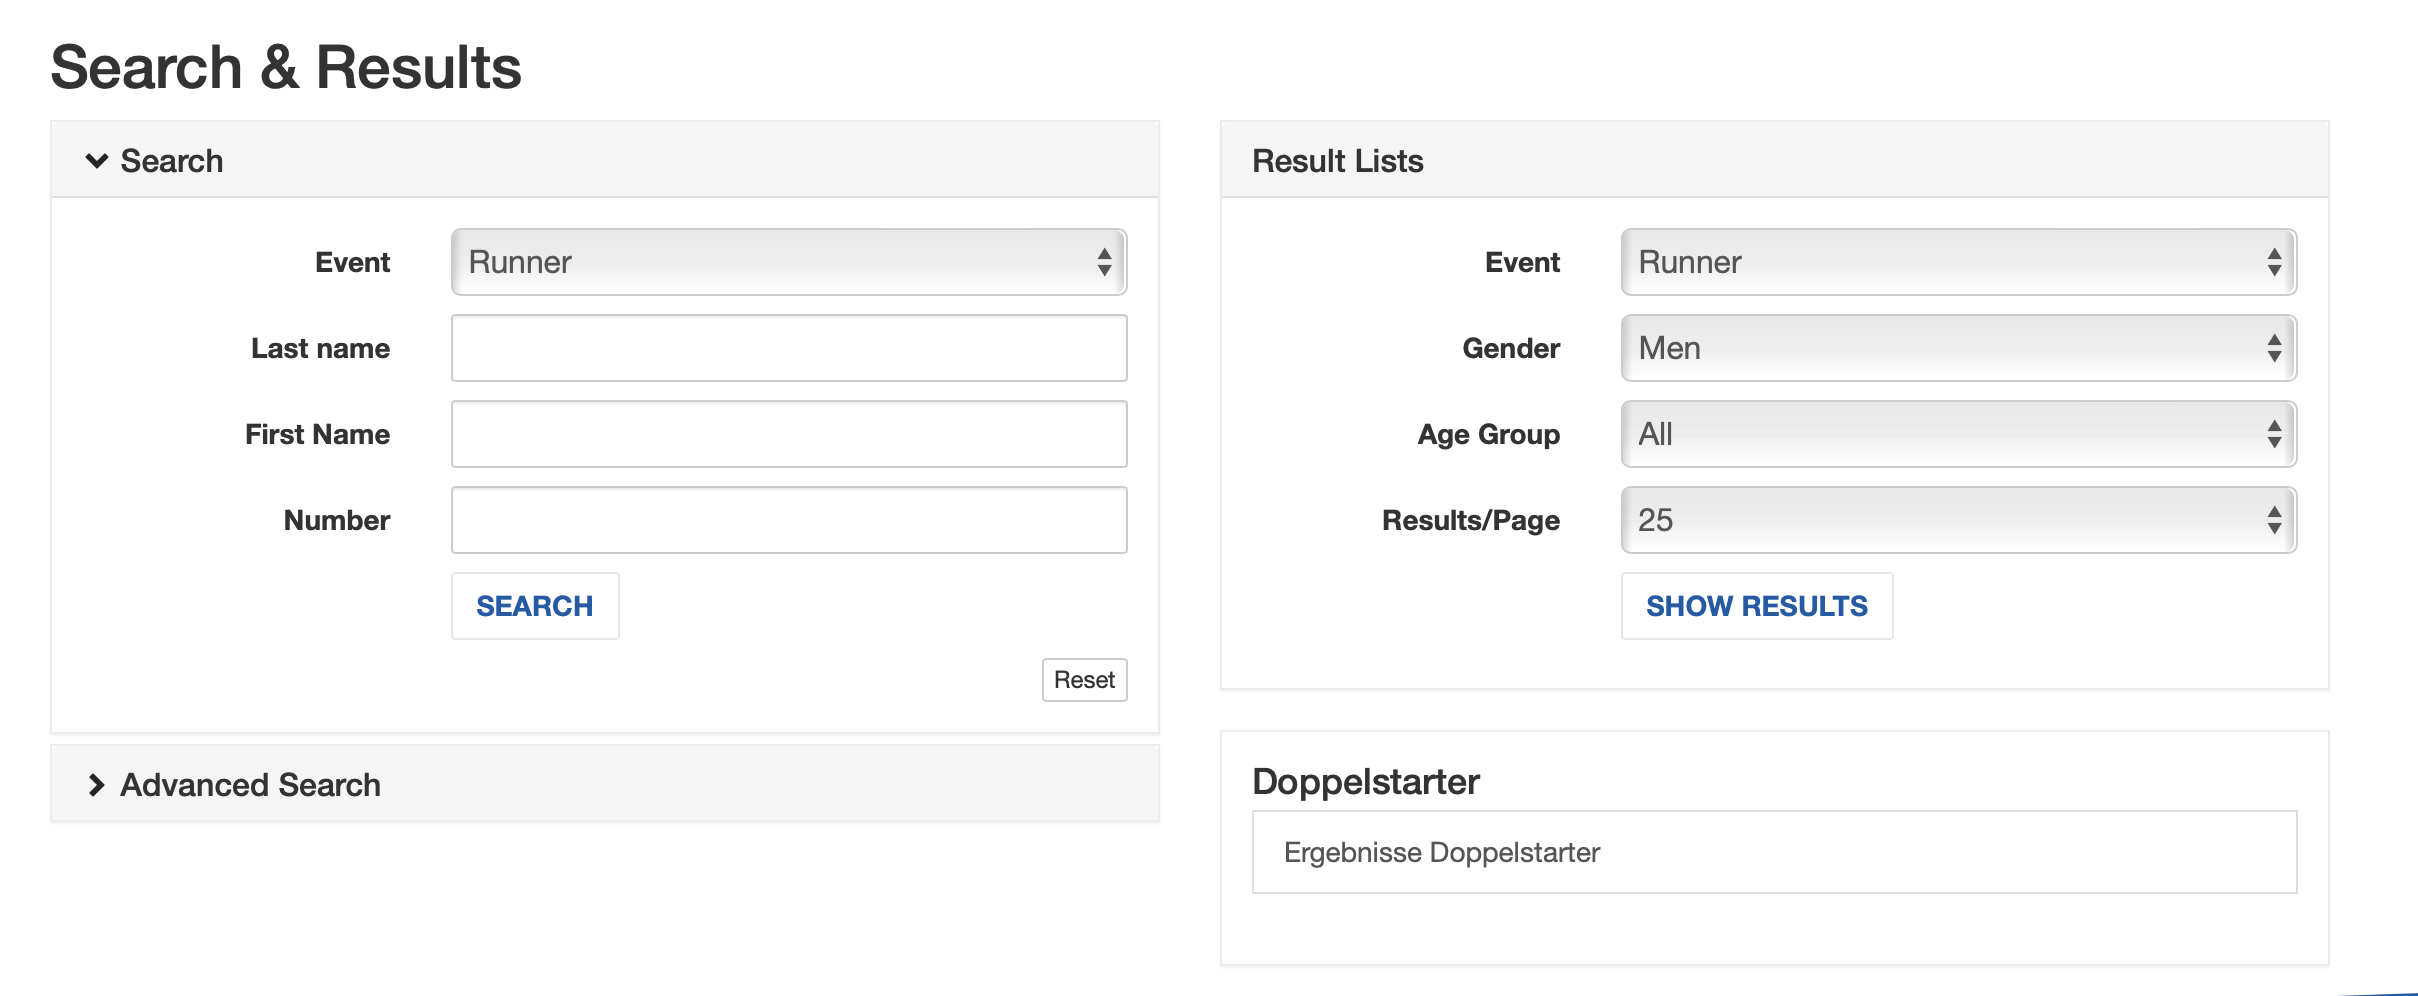

We focus on the upper right window: **Result Lists**

- Event: We choose *Runner* (there were also inline-skating or wheelchair) races
- Gender: There is no way to scrape both genders from one link, this will be a subject to a loop
- Age group: we can choose *All*
- Results/Page: we choose the maximum number, e.g. 100

Applying that, we obtain the following link: 


https://berlin.r.mikatiming.net/2021/?page=1&event=BML&num_results=100&pid=list&search%5Bsex%5D=M&search%5Bage_class%5D=%25

In the link, we need to go (loop) through two parameters to obtain all runners - gender and page number.

Gender can take two values Men (M) and Woman (W). We create a list of those two values:

In [3]:
genders = ["M", "W"]

Having 100 records per page, we get 64 pages for women and 168 pages for man. Hence we create a list of numbers from 1 to 168 (it shouldn't matter that we scrape through empty pages for women).

In [4]:
page_number = list(range(1, 169)) #the last number is not inclusive

In [5]:
##prepare all ingredients to obtain all the pages with results
url_first = 'https://berlin.r.mikatiming.net/2021/?page=' #link up to the page number
url_second = '&event=BML&num_results=100&pid=list&search%5Bsex%5D=' #middle part up to gender
url_third = '&search%5Bage_class%5D=%25' #last part of the link

#create an empty list to store results
pages = []

#loop to get all the pages and store it into the created array
for gender in genders:
    for page in page_number:
        pages.append(url_first + str(page) + url_second + gender + url_third)
        

#doublecheck, that we have obtained a correct number of links (twice the number of men's pages - 336)
len(pages) == 336

True

Now that we have all links to scrape from, let's use it to scrape link to each runners "personal" result page

In [6]:
#use the code from the lecture which returns nice soup code of the page
def getSoup(link):
    sleep(0.1) 
    r = requests.get(link)
    r.encoding = 'UTF-8'
    return BeautifulSoup(r.text)

In [7]:
#define the speficic function to get the personal links
def runners_pages(link):
    soup = getSoup(link)
    #the link can be found in h4 element of the page, this h4 is unique, thus the class does not need to be specified
    h4s = soup.find_all('h4')
    return ['https://berlin.r.mikatiming.net/2021/' + h4.find('a')['href'] for h4 in h4s]

In [15]:
#create an empty list once more to store all the "personal" links
personal_links = []
#we loop through all the pages with result to obtain the link to every single runner (should be around 25000 links) 
for page in pages:
    link = runners_pages(page)
    personal_links.append(link)

In [18]:
#we have obtained a list of lists - let's flatten it 
personal_links_flat = list(np.concatenate(personal_links).flat)

In [19]:
len(personal_links_flat)

23102

In [ ]:
#finally we can start building the final dataset